# CD7 Dimensionality reduction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [31]:
from ehv.masking import plot_scip_segmentation
from ehv.core import plot_gate_czi
from sklearn.preprocessing import scale, StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from sklearn.pipeline import make_pipeline
import flowutils

In [15]:
data_dir = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/results/scip/202203041148")

df = pq.read_table(data_dir / "features.parquet").to_pandas()

df = df.set_index(["meta_panel", "meta_replicate", "meta_P", "meta_id"])
df = df.loc["D"]
df = df.loc[numpy.load(data_dir / "neutrophils.npy", allow_pickle=True)]
df = df.sort_index()

In [16]:
df.shape

(32132, 1494)

In [23]:
%%time
tsne = TSNE(n_jobs=16, init="pca", learning_rate="auto").fit_transform(scale(df.filter(regex="feat.*(Bright|Oblique|PGC)")))

/data/gent/420/vsc42015/python_lib_skitty/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/data/gent/420/vsc42015/python_lib_skitty/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


CPU times: user 19min 22s, sys: 29.4 s, total: 19min 51s
Wall time: 2min 47s


<AxesSubplot:>

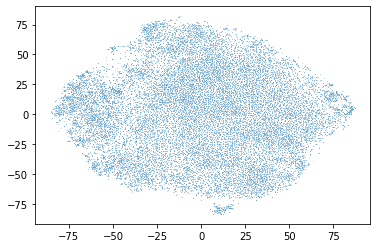

In [27]:
seaborn.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=0.5, alpha=0.8, edgecolors="none")

In [29]:
pca = PCA().fit_transform(scale(df.filter(regex="feat.*(Bright|Oblique|PGC)")))

/data/gent/420/vsc42015/python_lib_skitty/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


<AxesSubplot:>

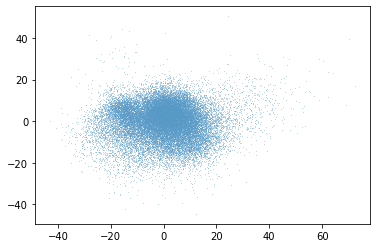

In [30]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], s=0.5, alpha=0.8, edgecolors="none")

In [33]:
%%time
umap_ = umap.UMAP(n_jobs=10).fit_transform(scale(df.filter(regex="feat.*(Bright|Oblique|PGC)")))

/data/gent/420/vsc42015/python_lib_skitty/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


CPU times: user 4min, sys: 2.25 s, total: 4min 2s
Wall time: 46 s


<AxesSubplot:>

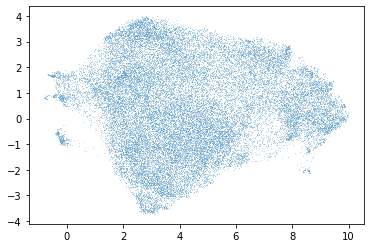

In [34]:
seaborn.scatterplot(x=umap_[:, 0], y=umap_[:, 1], s=0.5, alpha=0.8, edgecolors="none")